<a href="https://colab.research.google.com/github/annaiesenfeld/deltavsbacchus/blob/main/Image_Analysis_CompAssays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup 

In [56]:
!git clone https://gitlab.com/dunloplab/delta.git

!pip install -r delta/requirements.txt
!pip install python-bioformats

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:

import sys
sys.path.append('/content/delta')

import delta

In [58]:
delta.assets.download_assets(
    load_models=True,
    load_sets=False,
    load_evals=False,
    config_level='global'
)

Models will be downloaded to /content/delta/delta/assets/models
Config files written to /content/delta/delta/assets/config


In [59]:
from google.colab import drive

drive.mount('/content/gdrive2/', force_remount=True)

# To download files to your local drive:
from google.colab.files import download as colab_download
from google.colab.files import upload as colab_upload

# To display resuults movies:
from IPython.display import HTML
from base64 import b64encode

def display_movie(filename):
  mp4 = open(filename,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=600 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
  )

Mounted at /content/gdrive2/


In [60]:
# code to calculate crowdedness during a division event 
import math
import numpy as np

def get_colony(cells, mother_id):
  colony = []
  colony.append(mother_id)
  for cell in lin.cells:
    if cell['mother'] == mother_id or cell['mother'] in colony:
      colony.append(cell['id'])
                    
  return colony 


def get_centre(npole, opole): # get cell centre, using the coordinates between two poles of the cell 
  cell_centre = ((npole[0] + opole[0])/2 ,  (npole[1] + opole[1])/2)
  return cell_centre

def get_cell_dist(centre1, centre2): # get the distance between two cell centres 
  # dist = ((centre1[0] + centre2[0])/2 ,  (centre1[1] + centre2[1])/2)
  dist = math.sqrt(((centre1[0] - centre2[0])**2 + (centre1[1] - centre2[1])**2))
  return dist

def get_crowd_2(cell_dist, cell_length):
  crowd = math.e**((-cell_dist/cell_length))
  return crowd

# not useful - use centre 
def is_neighbour(centre1, c2_opole, c2_npole, cell1_l0):
  dist_opole = math.sqrt(((centre1[0] - c2_opole[0])**2 + (centre1[1] - c2_opole[1])**2))
  dist_npole = math.sqrt(((centre1[0] - c2_npole[0])**2 + (centre1[1] - c2_npole[1])**2))
  if dist_opole < 2*cell1_l0 or dist_npole < 2*cell1_l0: 
    return True 
  else: 
    return False 

def is_in_radius(centre1,cell1_l0,c2_opole, c2_npole): 
  radius = cell1_l0 * 2 
  return(((c2_opole[0] - centre1[0])**2 + (c2_opole[1] - centre1[1])**2) < radius **2 or  ((c2_npole[0] - centre1[0])**2 + (c2_npole[1] - centre1[1])**2) < radius **2)
  
def get_length_alt(npole, opole):
  cell_length = math.sqrt((opole[0]- npole[0])**2 + (opole[1]- npole[1])**2)
  return cell_length

def get_poleside(centre1, opole1, npole1, npole2, opole2, cell1_length, cell1_width):
  # substracting the coordinates of the centre of cell1 ( the cell in question) from the poles of all cells 
  # After this, the centre of cell 1 lies at 0,0 
  opole1_new = [opole1[0] - centre1[0], opole1[1] - centre1[1]]
  npole1_new = [npole1[0] - centre1[0] , npole1[1] - centre1[1]]
  npole2_new = [npole2[0] - centre1[0] , npole2[1] - centre1[1]]
  opole2_new = [opole2[0] - centre1[0] , opole2[1] - centre1[1]]
  # tan theta for cell 1: y(npole)- y(opole) / x(npole) -x(opole)
  # opole and npole is just delta nomenclature for the 2 poles 
  tantheta = (opole1[1]- npole1[1]) / (opole1[0]- npole1[0])
  # using arctan to get theta 
  theta = math.atan(tantheta)
  #  creating a rotation matrix, rot using the theta obtained 
  rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
  # multiplying each coordinate by rotation matrix to perform rotation
  opole1_rot = np.dot(rot, opole1_new)
  npole1_rot = np.dot(rot, npole1_new)
  opole2_rot = np.dot(rot, opole2_new)    
  npole2_rot = np.dot(rot, npole2_new)
  # now for each pole of cell 2 : 
  # first checking that the x coordinate lies within the length of cell 1 
  if abs(npole2_rot[0]) < cell1_length:
    # if that is the case, checking that the y coordinate is within 2w of cell1 
    if  abs(npole2_rot[1]) < 2*cell1_width:
      return True 
  elif abs(opole2_rot[0]) < cell1_length:
    if  abs(opole2_rot[1]) < 2*cell1_width:
      return True

# flipping the turn function in order to count the pole to side contacts but in the frame of cell 1 
def get_poleside_flipped(centre2, opole1, npole1, npole2, opole2, cell2_length, cell2_width):
  # substracting the coordinates of the centre of cell1 ( the cell in question) from the poles of all cells 
  # After this, the centre of cell 1 lies at 0,0 
  opole1_new = [opole1[0] - centre2[0], opole1[1] - centre2[1]]
  npole1_new = [npole1[0] - centre2[0] , npole1[1] - centre2[1]]
  npole2_new = [npole2[0] - centre2[0] , npole2[1] - centre2[1]]
  opole2_new = [opole2[0] - centre2[0] , opole2[1] - centre2[1]]
  # tan theta for cell 1: y(npole)- y(opole) / x(npole) -x(opole)
  # opole and npole is just delta nomenclature for the 2 poles 
  tantheta = (opole2[1]- npole2[1]) / (opole2[0]- npole2[0])
  # using arctan to get theta 
  theta = math.atan(tantheta)
  #  creating a rotation matrix, rot using the theta obtained 
  rot = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
  # multiplying each coordinate by rotation matrix to perform rotation
  opole1_rot = np.dot(rot, opole1_new)
  npole1_rot = np.dot(rot, npole1_new)
  opole2_rot = np.dot(rot, opole2_new)    
  npole2_rot = np.dot(rot, npole2_new)
  # now for each pole of cell 2 : 
  # first checking that the x coordinate lies within the length of cell 1 
  if abs(npole1_rot[0]) < cell2_length:
    # if that is the case, checking that the y coordinate is within 2w of cell1 
    if  abs(npole1_rot[1]) < 2*cell2_width:
      return True 
  elif abs(opole1_rot[0]) < cell2_length:
    if  abs(opole1_rot[1]) < 2*cell2_width:
      return True
 
 #Colony refinement 
def refine_colony(colony):
  for cnb in colony: 
    cell = lin.cells[cnb]
    npole1 = cell['new_pole'][-1]
    opole1 = cell['old_pole'][-1]
    # get centre of cell 1 for distance function 
    cell1_centre = get_centre(npole1, opole1)
    cell1_length = get_length_alt(npole1, opole1)
    cell1_width = cell['width'][0]
    neighbours = 0
    for cnb2 in lin.cellnumbers[-1]:
      if cnb2 not in colony: 
        cell2 = lin.cells[cnb2]
        npole2 = cell2['new_pole'][-1]
        opole2 = cell2['old_pole'][-1]
        cell2_centre = get_centre(npole2, opole2)
        cell2_length = cell2['length'][0]
        cell2_width = cell2['width'][0]
      if (get_cell_dist(opole1, npole2) < (2*cell1_width)) or (get_cell_dist(opole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, opole2) < (2*cell1_width)) or (get_cell_dist(npole1, npole2) < (2*cell1_width)): 
        if cnb2 not in colony: 
          colony.append(cnb2)
      
  return(colony)

  


#Sample Setup 

In [61]:

delta.config.load_config(presets='2D')

#these two lines might fix tracking issues: (only when actually running the pipeline)
delta.config.drift_correction = True
delta.config.whole_frame_drift = True

# # '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_unzipped',
#  # resfolder='/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/'

reader = delta.utilities.xpreader(
   '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvB_gm_RepBio1_RepT2_tl/unzipped',
    # prototype='Position%01d_Channel%01d_Frame%00002d.tif',
)

processor = delta.pipeline.Pipeline(
    reader,
    resfolder='/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvB_gm_RepBio1_RepT2_tl/eval_movie',
    reload=True
    )

Loading configuration from: /content/delta/delta/assets/config/config_2D.json


In [62]:
lin = processor.positions[0].rois[0].lineage


#Image Analysis

In [14]:
import os
import re
import pandas as pd
from tifffile import imread
from matplotlib import pyplot as plt
import numpy as np

In [7]:
# get image dimensions in pixels 
from PIL import Image
filepath = '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvB_gm_RepBio1_RepT2_tl/unzipped/Position01_Channel01_Frame000008.tif'
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height
  
# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)


The height of the image is:  2048
The width of the image is:  2048


In [8]:
import numpy as np

def create_cell_mask(w,h,centre, radius): 
  # w = width of image
  # h = height of image 
  # n = the frame you want to look at in a given moment 
  Y, X = np.ogrid[:h, :w]
  dist_from_center = np.sqrt((X - centre[0])**2 + (Y-centre[1])**2)
  mask = dist_from_center <= radius
  return mask

  

In [ ]:
print(lin.cells[48]['new_pole'])

[array([911, 892], dtype=int16)]


In [ ]:


delta.utilities.cell_fluo(GFP_folder, )

In [68]:
co_ch = {'wt':[], 'mnt':[]} # initialise dictionary of wt and mutant lineage ids
GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/GFP'
for gfp in os.listdir(GFP_folder):
  if re.search(r'T=31', gfp):
    gfp_img_path = GFP_folder+'/'+ gfp
    # print(gfp_img_path)

RFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/RFP'
for rfp in os.listdir(RFP_folder):
  if re.search(r'T=31', rfp):
    rfp_img_path = RFP_folder+'/'+ rfp
    # print(rfp_img_path)

imageGfp = imread(gfp_img_path) # open RFP and GFP images
imageRfp = imread(rfp_img_path)

for c in lin.cellnumbers[30]: 
  # print(c)
  cell = lin.cells[c]
  j= cell['frames'].index(30)
  cell_npole = cell['new_pole'][j]
  cell_opole = cell['old_pole'][j]
  cell_centre = get_centre(cell_npole, cell_opole)
  # print(cell_centre)
  cell_radius = (cell['width'][0])
  mask = create_cell_mask(2048,2048, cell_centre, cell_radius )

  gfp_intensity, rfp_intensity = sum(imageGfp[mask]), sum(imageRfp[mask])
  if rfp_intensity > gfp_intensity :
    if c not in co_ch['mnt']:
      co_ch['mnt'].append(c)
      print(str(c), 'mnt')
  if gfp_intensity > rfp_intensity:
    if c not in co_ch['wt']:
      co_ch['wt'].append(c)
      # print(str(c),'wt')

4762 mnt
2329 mnt
4178 mnt
576 mnt
1354 mnt
2875 mnt
134 mnt
684 mnt
4763 mnt
2344 mnt
133 mnt
4767 mnt
4778 mnt
1988 mnt
4190 mnt
4776 mnt
2331 mnt
1359 mnt
357 mnt
2880 mnt
356 mnt
2349 mnt
4789 mnt
2878 mnt
4793 mnt
1357 mnt
3554 mnt
2881 mnt
1994 mnt
2364 mnt
504 mnt
1361 mnt
1998 mnt
358 mnt
2007 mnt
2001 mnt
3573 mnt
3434 mnt
1363 mnt
3575 mnt
4640 mnt
4239 mnt
1009 mnt
4834 mnt
1010 mnt
3586 mnt
599 mnt
1367 mnt
4074 mnt
2902 mnt
4841 mnt
4252 mnt
4262 mnt
1370 mnt
1129 mnt
4896 mnt
429 mnt
3627 mnt
3638 mnt
221 mnt
4894 mnt
2951 mnt
369 mnt
2394 mnt
3660 mnt
4090 mnt
2407 mnt
4093 mnt
1383 mnt
4095 mnt
437 mnt
3644 mnt
440 mnt
2411 mnt
4290 mnt
1404 mnt
1736 mnt
4903 mnt
4904 mnt
1393 mnt
2957 mnt
1387 mnt
6 mnt
223 mnt
3682 mnt
5299 mnt
2409 mnt
608 mnt
2413 mnt
3684 mnt
1710 mnt
2954 mnt
2962 mnt
2428 mnt
5300 mnt
3449 mnt
3451 mnt
281 mnt
139 mnt
370 mnt
2967 mnt
1750 mnt
3680 mnt
3683 mnt
1728 mnt
2980 mnt
3456 mnt
3678 mnt
2791 mnt
1734 mnt
2993 mnt
2975 mnt
2976 mnt
3697 

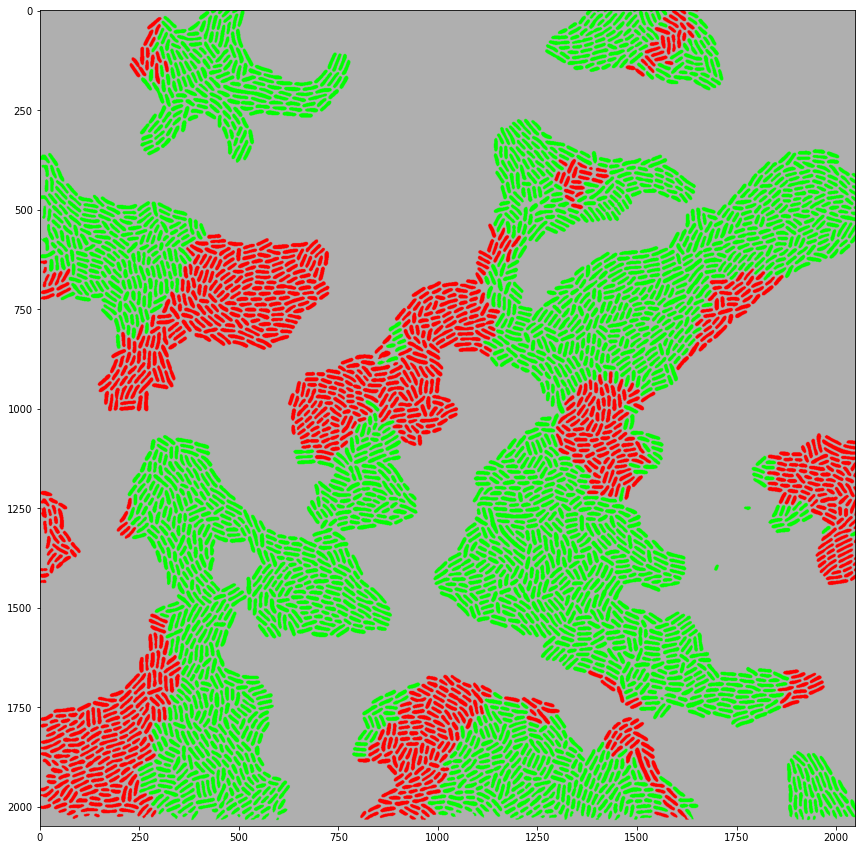

In [70]:
# check that colony looks good 

import numpy as np


labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# colony1 = get_colony(lin.cells, 1)
# colony2 = get_colony(lin.cells, 2)

# colony = colony1 + colony2


# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[30]:
  if cell in co_ch['mnt']:
    color = [255,0,0]
  elif cell in co_ch['wt']:
    color = [0,255,0]
  else:
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)

{'id': 0, 'mother': None, 'frames': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'daughters': [None, 42, None, None, None, None, None, 95, None, None, None, 177, None, None, None, 360, None, None, None, 686, None, None, None, None, None, None, 2360, None, None, None, 4795], 'new_pole': [array([  33, 1531], dtype=int16), array([  18, 1504], dtype=int16), array([  15, 1504], dtype=int16), array([  12, 1507], dtype=int16), array([  13, 1506], dtype=int16), array([  13, 1506], dtype=int16), array([  12, 1505], dtype=int16), array([  35, 1496], dtype=int16), array([  14, 1492], dtype=int16), array([   7, 1486], dtype=int16), array([   4, 1480], dtype=int16), array([  34, 1488], dtype=int16), array([  35, 1489], dtype=int16), array([  37, 1487], dtype=int16), array([  41, 1489], dtype=int16), array([  61, 1505], dtype=int16), array([  60, 1499], dtype=int16), array([  67, 1500], dtype=int16), array([  69, 1504], dtype=int

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


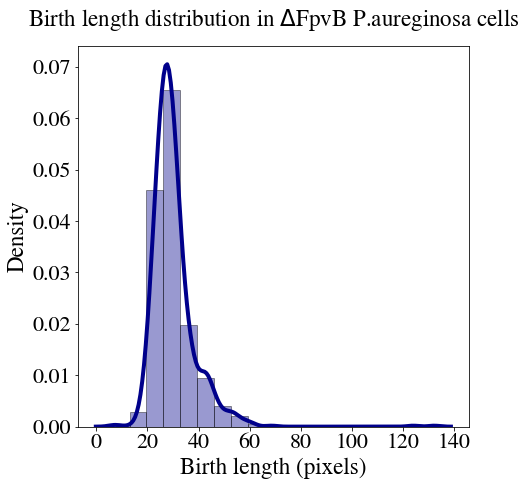

30.20346850514533 8.665445185897363


In [76]:
import seaborn as sns
import statistics as stats

first_cells = lin.cells[0]
print(first_cells)

pop_birth_lengths=[]
for cell in lin.cells: 
  if cell['id'] in co_ch['mnt']:
    if cell['id'] in first_cells or cell['mother'] is not None: 
      birth_length = cell['length'][0]
      pop_birth_lengths.append(birth_length)


plt.figure(figsize=(7,7))
ax2 = sns.distplot(pop_birth_lengths, hist=True, kde=True, 
             bins=int(len(pop_birth_lengths)/50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_ylabel('Density', fontname = 'STIXGeneral', fontsize = 23)
ax2.set_xlabel('Birth length (pixels)', fontname = 'STIXGeneral', fontsize = 23)
ax2.set_title ('Birth length distribution in $\Delta$FpvB P.aureginosa cells', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
# ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
# ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
ylabels = plt.yticks(fontname = 'STIXGeneral', fontsize=22)
xlabels = plt.xticks(fontname = 'STIXGeneral', fontsize=22)
plt.show()

print(stats.mean(pop_birth_lengths), stats.stdev(pop_birth_lengths))



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


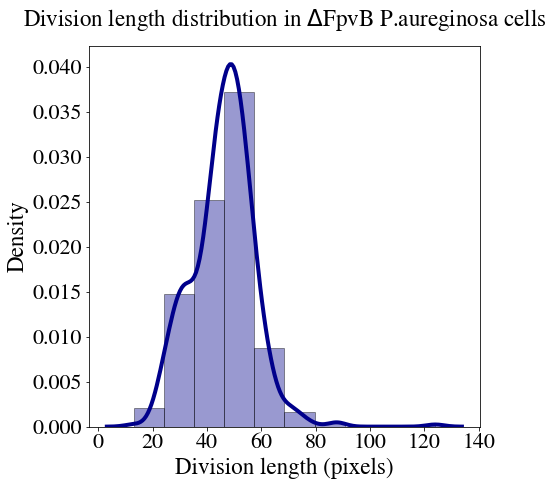

46.07603754051001 11.414207610260831


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib import rc
import statistics as stat
from matplotlib.pyplot import figure

lin = processor.positions[0].rois[0].lineage

first_cells = lin.cellnumbers[0]

pop_div_lengths = []
div_frames = []
pop_birth_lengths = []

for cell in lin.cells: 
  if cell['id'] in co_ch['mnt']:
    daughters = [cell['daughters'].index(daughter) for daughter in cell['daughters'] if daughter is not None]
    for daughter in daughters: 
      if daughters.index(daughter) == 0: 
        div_len_idx = daughter - 1 
        div_length = cell['length'][div_len_idx] 
        div_frame = cell['frames'][div_len_idx] 
        pop_div_lengths.append(div_length)
        pop_birth_lengths.append(cell['length'][0])
        div_frames.append(div_frame)
      
        


plt.figure(figsize=(7,7))
ax = sns.distplot(pop_div_lengths, hist=True, kde=True, 
             bins=int(len(pop_div_lengths)/50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Density', fontname = 'STIXGeneral', fontsize = 23)
ax.set_xlabel('Division length (pixels)', fontname = 'STIXGeneral', fontsize = 23)
ax.set_title ('Division length distribution in $\Delta$FpvB P.aureginosa cells', fontname = 'STIXGeneral', fontsize = 23, pad = 20)
# ax.set_xticklabels(fontname = 'STIXGeneral', fontsize=20)
# ax.set_yticks(fontname = 'STIXGeneral', fontsize=20)
ylabels = plt.yticks(fontname = 'STIXGeneral', fontsize=22)
xlabels = plt.xticks(fontname = 'STIXGeneral', fontsize=22)
plt.show()

print(stats.mean(pop_div_lengths), stats.stdev(pop_div_lengths))

# plt.scatter(div_frames,pop_div_lengths)
# plt.xlabel('Division frame', fontname = 'STIXGeneral', fontsize=20)
# plt.ylabel('Division length (pixels)', fontname = 'STIXGeneral',  fontsize=20)
# # plt.title('Division length in WT P.aureginosa as a function of division frame')
# plt.title('Division length in WT P.aureginosa as a function of division frame',fontname = 'STIXGeneral', fontsize=20, pad =20)
# plt.xticks(fontname = 'STIXGeneral', fontsize=20)
# plt.yticks(fontname = 'STIXGeneral', fontsize=20)
# figure(figsize=(20,16))
# plt.show()


In [25]:
co_ch = {'wt':[], 'mnt':[]} # initialise dictionary of wt and mutant lineage ids
GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/GFP'
for gfp in os.listdir(GFP_folder):
  if re.search(r'T=20', gfp):
    gfp_img_path = GFP_folder+'/'+ gfp
    # print(gfp_img_path)

RFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/RFP'
for rfp in os.listdir(RFP_folder):
  if re.search(r'T=20', rfp):
    rfp_img_path = RFP_folder+'/'+ rfp
    # print(rfp_img_path)

imageGfp = imread(gfp_img_path) # open RFP and GFP images
imageRfp = imread(rfp_img_path)

for c in lin.cellnumbers[20]: 
  # print(c)
  cell = lin.cells[c]
  j= cell['frames'].index(20)
  cell_npole = cell['new_pole'][j]
  cell_opole = cell['old_pole'][j]
  cell_centre = get_centre(cell_npole, cell_opole)
  # print(cell_centre)
  cell_radius = (cell['width'][0])
  mask = create_cell_mask(2048,2048, cell_centre, cell_radius )
  fluo = delta.utilities.cell_fluo(, mask)


IndexError: ignored

In [ ]:



co_ch = {'wt':[], 'mnt':[]} # initialise dictionary of wt and mutant lineage ids
GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/GFP'
RFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/RFP'



for i in range(0,29):
  print('frame:'+ str(i))
  for gfp in os.listdir(GFP_folder):
    if re.search(r'T=%i', gfp):
      gfp_img_path = GFP_folder+'/'+ gfp
      print(gfp_img_path)


  for rfp in os.listdir(RFP_folder):
    if re.search(r'T=%i', rfp):
      rfp_img_path = RFP_folder+'/'+ rfp
      print(rfp_img_path)

  imageGfp = imread(gfp_img_path) # open RFP and GFP images
  imageRfp = imread(rfp_img_path)
  
  for c in lin.cellnumbers[i]: 
    # print(c)
    cell = lin.cells[c]
    j= cell['frames'].index(i)
    cell_npole = cell['new_pole'][j]
    cell_opole = cell['old_pole'][j]
    cell_centre = get_centre(cell_npole, cell_opole)
    # print(cell_centre)
    cell_radius = (cell['width'][0])
    mask = create_cell_mask(2048,2048, cell_centre, cell_radius )

    

    gfp_intensity, rfp_intensity = sum(imageGfp[mask]), sum(imageRfp[mask])
    if rfp_intensity > gfp_intensity/5:
      if c not in co_ch['mnt']:
        co_ch['mnt'].append(c)
        print(str(c), 'mnt')
    elif gfp_intensity/5 > rfp_intensity:
      if c not in co_ch['wt']:
        co_ch['wt'].append(c)
        print(str(c),'wt')
        


In [ ]:

# co_ch = {'wt':[], 'mnt':[]} # initialise dictionary of wt and mutant lineage ids
# GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/GFP'
# for gfp in os.listdir(GFP_folder):
#   if re.search(r'T=20', gfp):
#     gfp_img_path = GFP_folder+'/'+ gfp
#     # print(gfp_img_path)

# RFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/RFP'
# for rfp in os.listdir(RFP_folder):
#   if re.search(r'T=20', rfp):
#     rfp_img_path = RFP_folder+'/'+ rfp
#     # print(rfp_img_path)

# imageGfp = imread(gfp_img_path) # open RFP and GFP images
# imageRfp = imread(rfp_img_path)

# for c in lin.cellnumbers[20]: 
#   # print(c)
#   cell = lin.cells[c]
#   j= cell['frames'].index(20)
#   cell_npole = cell['new_pole'][j]
#   cell_opole = cell['old_pole'][j]
#   cell_centre = get_centre(cell_npole, cell_opole)
#   # print(cell_centre)
#   cell_radius = (cell['width'][0])
#   mask = create_cell_mask(2048,2048, cell_centre, cell_radius )

#   gfp_intensity, rfp_intensity = sum(imageGfp[mask]), sum(imageRfp[mask])
#   if rfp_intensity > gfp_intensity/2 :
#     if c not in co_ch['mnt']:
#       co_ch['mnt'].append(c)
#       print(str(c), 'mnt')
#   if gfp_intensity/3 > rfp_intensity:
#     if c not in co_ch['wt']:
#       co_ch['wt'].append(c)
#       print(str(c),'wt')


In [52]:
print(len(lin.cellnumbers))

31


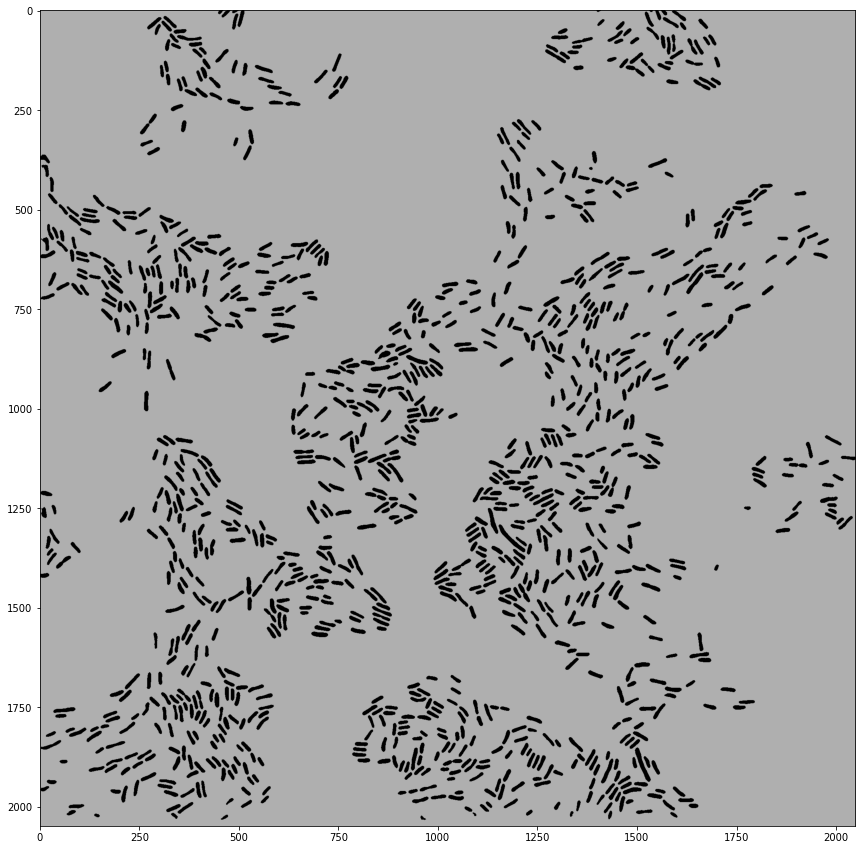

In [55]:
# check that colony looks good 

import numpy as np


labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# colony1 = get_colony(lin.cells, 1)
# colony2 = get_colony(lin.cells, 2)

# colony = colony1 + colony2


# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[24]:
  color = [0,0,0]
  # if cell in co_ch['mnt']:
  #   color = [0,0,255]
  # elif cell in co_ch['wt']:
  #   color = [0,255,0]
  # else:
  #    color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)

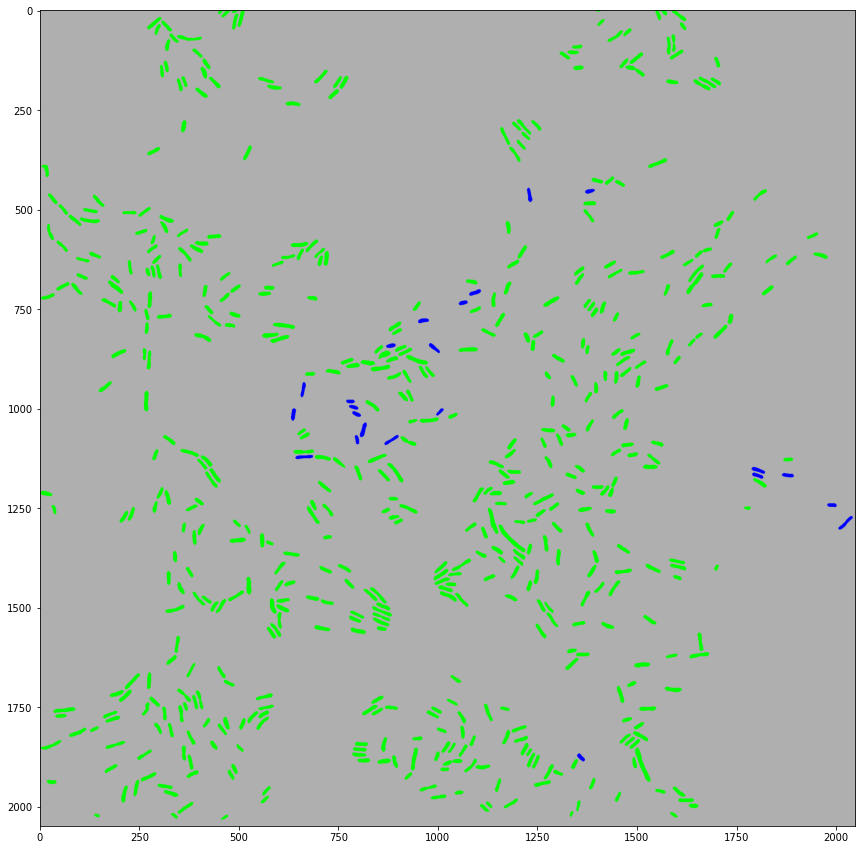

In [ ]:
# check that colony looks good 

import numpy as np


labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# colony1 = get_colony(lin.cells, 1)
# colony2 = get_colony(lin.cells, 2)

# colony = colony1 + colony2


# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[20]:
  if cell in co_ch['mnt']:
    color = [0,0,255]
  elif cell in co_ch['wt']:
    color = [0,255,0]
  else:
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)

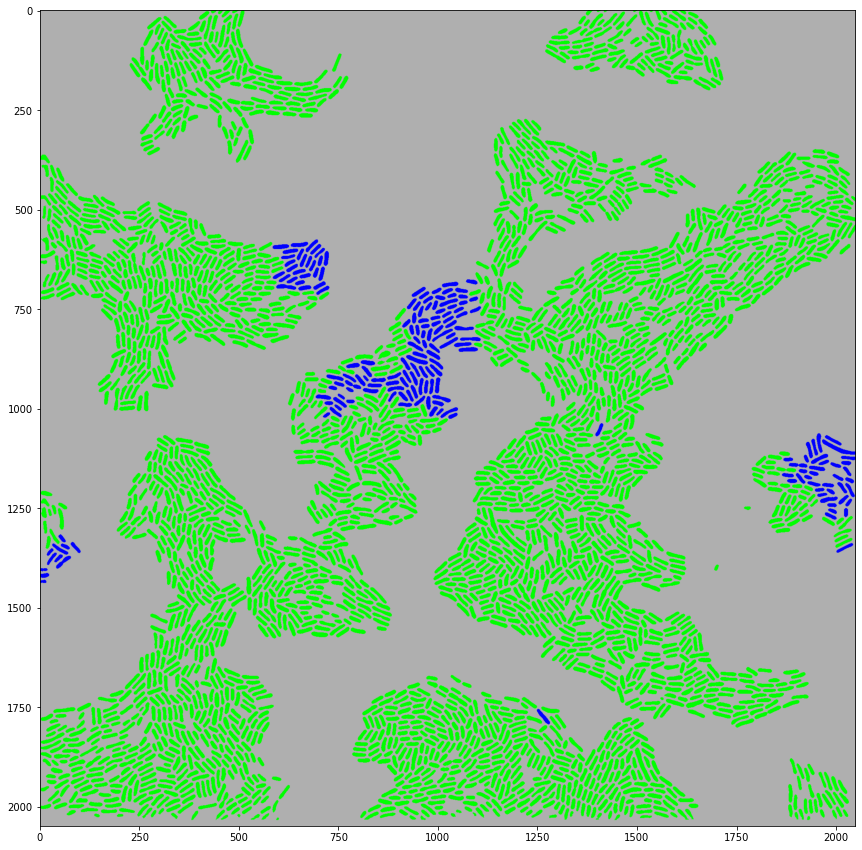

In [ ]:
# check that colony looks good 

import numpy as np


labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# colony1 = get_colony(lin.cells, 1)
# colony2 = get_colony(lin.cells, 2)

# colony = colony1 + colony2


# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[-2]:
  if cell in co_ch['mnt']:
    color = [0,0,255]
  elif cell in co_ch['wt']:
    color = [0,255,0]
  else:
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)

In [ ]:
#  create copy of lin.cells for modification 
import copy

lin.cells2 = copy.deepcopy(lin.cells)

In [ ]:
import os 
GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/GFP'
for gfp in os.listdir(GFP_folder):
  if re.search(r'T=0\b', gfp):
    gfp_img_path = GFP_folder+'/'+ gfp
    print(gfp_img_path)
    break

  #  T_ = file.split('T=',2)
  #  T = T_[1][0]+T_[1][1]
   
imageGfp = imread(gfp_img_path)
  



/content/gdrive2/.shortcut-targets-by-id/1sR73S8JfI8yRgqG052uxjiO46rLG1Hho/vsFpvB_gm_RepBio1_RepT2/GFP/frame_t_0.ets - 021 PH, TRITC_LED100%, FITC_LED100%, DAPI_LED100% - T=0 C=2.tif


In [ ]:
imageGfp

array([[16, 14, 34, ..., 23, 33, 13],
       [22, 37, 14, ..., 24, 20, 30],
       [19,  8, 24, ..., 33, 20, 41],
       ...,
       [27, 37, 19, ..., 36, 29, 34],
       [27, 40, 30, ..., 37, 26, 21],
       [33, 27, 30, ..., 26, 33, 16]], dtype=uint16)

In [ ]:
# get centre 

for cnb in lin.cellnumbers[0]:
  cell = lin.cells2[cnb]
  cell_npole = cell['new_pole'][0]
  cell_opole = cell['old_pole'][0]
  cell_centre = get_centre(cell_npole, cell_opole)
  print(cell_centre)




# Image analysis but for vsA 

In [ ]:
delta.config.load_config(presets='2D')

#these two lines might fix tracking issues: (only when actually running the pipeline)
delta.config.drift_correction = True
delta.config.whole_frame_drift = True

# # '/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_unzipped',
#  # resfolder='/content/gdrive/MyDrive/A_Gm_Rep1_Ph_run/A_Gm_Rep1_eval_movie2/'

reader = delta.utilities.xpreader(
   '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT2_tl/unzipped_images',
    # prototype='Position%01d_Channel%01d_Frame%00002d.tif',
)

processor = delta.pipeline.Pipeline(
    reader,
    resfolder='/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT2_tl/eval_movie',
    reload=True
    )

Loading configuration from: /content/delta/delta/assets/config/config_2D.json


In [ ]:
lin = processor.positions[0].rois[0].lineage

In [ ]:
for cell in lin.cells: 
  print(cell['width'])

In [ ]:
co_ch = {'wt':[], 'mnt':[]} # initialise dictionary of wt and mutant lineage ids

for i in range(0,29):
  print('frame:'+ str(i))
  GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT2_tl/Rep2/GFP'
  for gfp in os.listdir(GFP_folder):
    if re.search(r'T=%i', gfp):
      gfp_img_path = GFP_folder+'/'+ gfp
      # print(gfp_img_path)

  RFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1PFWG3Y6nCG2LwgS7ZYW9SVyGoRCzbaZI/Delta2Runs/vsFpvA_gm_RepBio1_RepT2_tl/Rep2/RFP'
  for rfp in os.listdir(RFP_folder):
    if re.search(r'T=%i', rfp):
      rfp_img_path = RFP_folder+'/'+ rfp
      print(rfp_img_path)

  
  for c in lin.cellnumbers[i]: 
    # print(c)
    cell = lin.cells[c]
    j= cell['frames'].index(i)
    cell_npole = cell['new_pole'][j]
    cell_opole = cell['old_pole'][j]
    cell_centre = get_centre(cell_npole, cell_opole)
    # print(cell_centre)
    cell_radius = (cell['width'][0])
    mask = create_cell_mask(2048,2048, cell_centre, 6)

    imageGfp = imread(gfp_img_path) # open RFP and GFP images
    imageRfp = imread(rfp_img_path)

    gfp_intensity, rfp_intensity = sum(imageGfp[mask]), sum(imageRfp[mask])
    print(gfp_intensity, rfp_intensity)
    if rfp_intensity > gfp_intensity :
      print(str(c), 'mnt')
      if c not in co_ch['mnt']:
        co_ch['mnt'].append(c)
    if gfp_intensity > rfp_intensity:
      if c not in co_ch['wt']:
        co_ch['wt'].append(c)
        print(str(c),'wt')
  

Streaming output truncated to the last 5000 lines.
7388 861
29175 784
35332 712
64694 948
34254 626
31583 689
33601 760
38605 855
47573 931
35299 782
953 wt
7071 977
33616 760
1016 wt
6620 895
5935 1048
58928 1146
954 wt
6088 1064
33275 776
30125 716
1017 wt
12907 543
955 wt
29738 734
1018 wt
39858 1042
15617 721
28724 757
16381 685
956 wt
12791 687
26925 737
1019 wt
5731 1036
5500 907
5936 1151
32983 811
10986 687
5861 1184
11708 615
37624 1048
13733 615
21148 846
6564 1491
12070 743
957 wt
6873 1491
6909 1486
20107 885
21071 959
11483 615
20016 841
18834 913
11199 721
958 wt
7008 1972
18996 843
54316 962
11567 647
1020 wt
50049 994
16156 865
44543 942
17854 847
6915 2905
55385 1042
6850 2238
17157 903
54105 987
10049 602
1021 wt
15092 1014
11214 638
53371 1042
10172 691
1022 wt
50606 1155
13256 864
12474 691
15036 822
55804 1112
52765 947
13420 674
47386 1162
9377 631
1023 wt
8081 666
53934 1092
47587 925
10133 812
959 wt
11340 815
1024 wt
10295 883
12258 747
10118 894
59151 1054
487

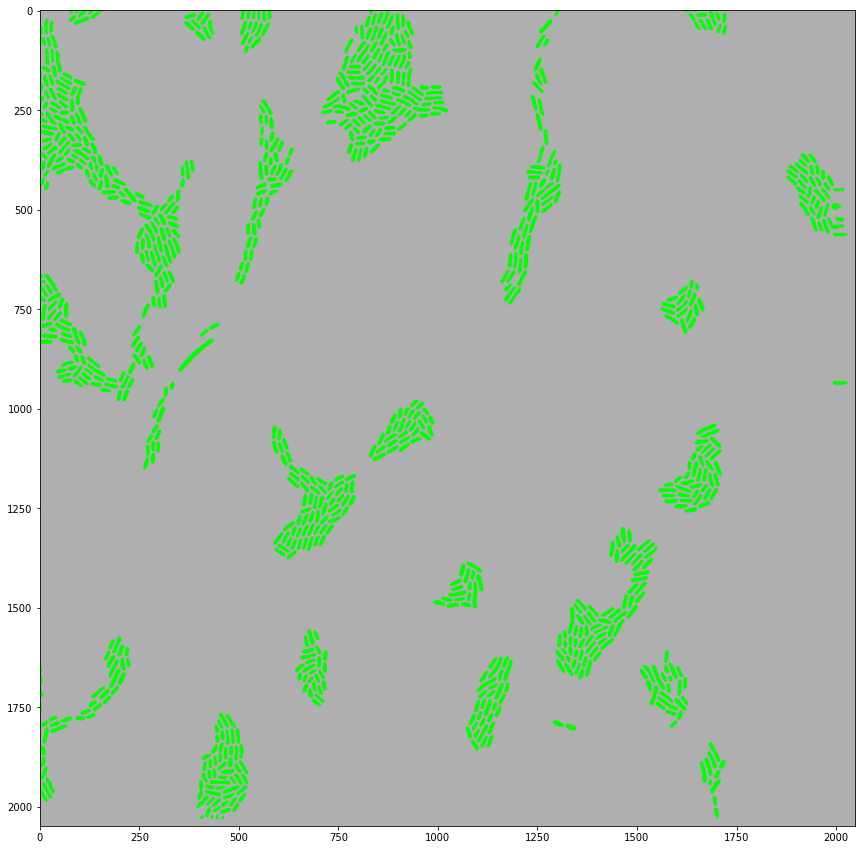

In [ ]:
# check that colony looks good 

import numpy as np


labels = processor.positions[0].rois[0].label_stack[-1]

# Initialize color image (all light gray)
color_image = np.full(
    shape=labels.shape+(3,),
    fill_value=175,
    dtype=np.uint8
    )

# colony1 = get_colony(lin.cells, 1)
# colony2 = get_colony(lin.cells, 2)

# colony = colony1 + colony2


# col_1011_cids, col_1011_neighbours, col_1011_cycles = numneighbours_immediate(colony_1011)

for cell in lin.cellnumbers[-2]:
  if cell in co_ch['mnt']:
    color = [0,0,255]
  elif cell in co_ch['wt']:
    color = [0,255,0]
  else:
     color = [0,0,0]


  for c, val in enumerate(color):
      color_image[:,:,c][labels==cell+1]=val
      



plt.figure(figsize = (15,15))
plt.imshow(color_image)

In [ ]:
print(len(co_ch['mnt']))

4


In [ ]:
GFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1qthuP1OIiIg1Lnw7lfFtx1ueNMHZemtI/FpvA_gm_RepBio1_Rep2T/GFP'
for gfp in os.listdir(GFP_folder):
  if re.search(r'T=30', gfp):
    gfp_img_path = GFP_folder+'/'+ gfp
    # print(gfp_img_path)

RFP_folder = '/content/gdrive2/.shortcut-targets-by-id/1qthuP1OIiIg1Lnw7lfFtx1ueNMHZemtI/FpvA_gm_RepBio1_Rep2T/RFP'
for rfp in os.listdir(RFP_folder):
  if re.search(r'T=30', rfp):
    rfp_img_path = RFP_folder+'/'+ rfp
    # print(rfp_img_path)

imageGfp = imread(gfp_img_path) # open RFP and GFP images
imageRfp = imread(rfp_img_path)

for c in lin.cellnumbers[-1]: 
  # print(c)
  cell = lin.cells[c]
  # j= cell['frames'].index(i)
  cell_npole = cell['new_pole'][-1]
  cell_opole = cell['old_pole'][-1]
  cell_centre = get_centre(cell_npole, cell_opole)
  # print(cell_centre)
  cell_radius = (cell['width'][0])
  mask = create_cell_mask(2048,2048, cell_centre, cell_radius )

  gfp_intensity, rfp_intensity = sum(imageGfp[mask]), sum(imageRfp[mask])
  print(gfp_intensity, rfp_intensity)
  if rfp_intensity > gfp_intensity:
      print(str(c), 'mnt')
  if gfp_intensity > rfp_intensity:
      # print(str(c),'wt')
      print('/')


7373 830
4426 243
3622 325
2761 410
6980 685
14393 2129
5900 583
7783 921
114503 2105
19691 1924
9617 1183
122699 2129
79377 2897
63872 2781
86843 4092
10858 1362
53637 10761
38870 3370
81400 4145
81992 2234
20321 1269
9989 1131
62007 7986
32503 1686
11396 1721
95685 2539
16372 2330
12861 1456
16408 2361
31016 2111
19756 2736
11736 1827
12091 1686
32874 1606
83650 2500
19918 1581
12591 1149
14718 2162
31623 2161
22230 1779
11282 935
29876 1771
124035 3538
61132 1418
4699 508
7833 573
97871 3141
19179 1344
35070 1682
12841 1590
140636 3810
17022 2638
128567 3532
107603 3060
12428 1722
14588 1703
35382 2011
25235 2720
5998 640
23811 1609
15903 1656
85997 2388
27503 2245
12450 1637
42999 989
16025 1876
29804 1586
16492 1337
21864 2615
17688 1879
11792 1175
108993 3134
33340 1950
16796 1822
24130 2514
24770 1948
64574 4479
22869 1981
25508 1996
106817 2817
35787 2367
33139 2071
31481 1827
28477 2430
31279 2123
40686 2467
9139 906
36289 2081
44280 2427
42037 2375
15574 1552
33608 1888
38956

KeyboardInterrupt: ignored